In [89]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import *
from sklearn.metrics import *

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings("ignore")

In [91]:
path = "~/isomirs/Bimodal_mir22/"
df = pd.read_csv(path+'isomiR_CPM.tsv', sep = '\t')
cond_cancer = df.columns.str.contains('-0[1-9][A-Z]', regex = True)
df_cancer = df[df.columns[cond_cancer]]

mirna22 = df_cancer.loc["hsa-miR-22-3p|+1|0"] 
left, right = mirna22[mirna22 < 11].index, mirna22[mirna22 > 11].index

In [92]:
data = pd.read_csv("TCGA-BRCA.GDC_phenotype.tsv", sep = '\t', index_col = 0)
cond_cancer = data.index.str.contains('-0[1-9][A-Z]', regex = True)
data = data[cond_cancer]
data = data.replace(r'Not Reported|not reported', np.NaN, regex = True)
mask = (data.isna().sum() > data.shape[0]/2) | data.columns.str.contains('id|code|file_name', regex = True)
data = data[data.columns[~mask]]

y = np.array([1 if i in left else 0 for i in data.index])

In [120]:
data['batch_number'].unique()

array(['103.79.0', '109.89.0', '117.79.0', '120.77.0', '124.81.0',
       '136.77.0', '142.79.0', '147.76.0', '155.74.0', '167.75.0',
       '177.74.0', '185.70.0', '202.70.0', '216.64.0', '227.61.0',
       '234.54.0', '239.56.0', '255.57.0', '271.57.0', '288.55.0',
       '296.55.0', '305.51.0', '322.50.0', '334.46.0', '338.46.0',
       '360.43.0', '372.40.0', '379.35.0', '47.98.0', '56.91.0',
       '61.89.0', '72.91.0', '74.88.0', '80.80.0', '80.84.0', '85.86.0',
       '93.87.0', '96.80.0'], dtype=object)

In [94]:
label_encoder = LabelEncoder()
data_encode = data.apply(label_encoder.fit_transform)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    data_encode.to_numpy(), y, test_size=0.3, random_state = 42, stratify=y
)

# scaler = StandardScaler().fit(X_train)
# X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [96]:
def metrics(model, y_test, X_test, name):
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    fig, axs = plt.subplots(1, 2, figsize = (20, 8))
    # строим ROC-кривую
    axs[0].set_title('ROC ')
    plot_roc_curve(model, X_test, y_test, ax = axs[0])
    axs[0].plot(fpr[1], tpr[1], color = 'red', marker = '*', markersize = 10)
    axs[0].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')

    # строим confusion_matrix, чтобы посмотреть где модель больше ошибается
    axs[1].set_title('Confusion matrix')
    sns.heatmap(confusion_matrix(y_test, y_pred),  cmap="BuPu", annot = True, ax = axs[1])
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Real');
    
    return  pd.DataFrame([accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred), 
                          precision_score(y_test, y_pred), recall_score(y_test, y_pred)],
                         index = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall'],
                         columns =[name]).T

In [66]:
Random_forest = RandomForestClassifier(n_estimators = 50)
params = {"max_depth": [1, 3, 5, 7, 10, 15, 20],
         "min_samples_split": [1, 3, 5, 7, 10, 15, 20]}
        
cv = GridSearchCV(
    Random_forest, params,
    scoring=make_scorer(f1_score),
    cv=RepeatedStratifiedKFold(n_repeats=10)).fit(X_train, y_train)

RF_params = cv.best_params_
print(RF_params)

{'max_depth': 20, 'min_samples_split': 3}


In [97]:
Dtree = DecisionTreeClassifier()       
cv_tree = GridSearchCV(
    Dtree, params,
    scoring=make_scorer(f1_score),
    cv=RepeatedStratifiedKFold(n_repeats=10)).fit(X_train, y_train)

DT_params = cv_tree.best_params_
print(DT_params)

{'max_depth': 7, 'min_samples_split': 20}


In [98]:
Random_forest_best = RandomForestClassifier(n_estimators = 50, 
                                            max_depth = RF_params["max_depth"], 
                                            min_samples_split = RF_params["min_samples_split"]
                                           ).fit(X_train, y_train)

Dtree_best = DecisionTreeClassifier(max_depth = 3,
                                    min_samples_split = DT_params["min_samples_split"]
                                   ).fit(X_train, y_train)

Bagging = BaggingClassifier(base_estimator=Dtree_best, n_estimators = 50).fit(X_train, y_train)

## Decision tree

,Accuracy,ROC-AUC,Precision,Recall
Decision tree,0.872404,0.842489,0.9,0.731707


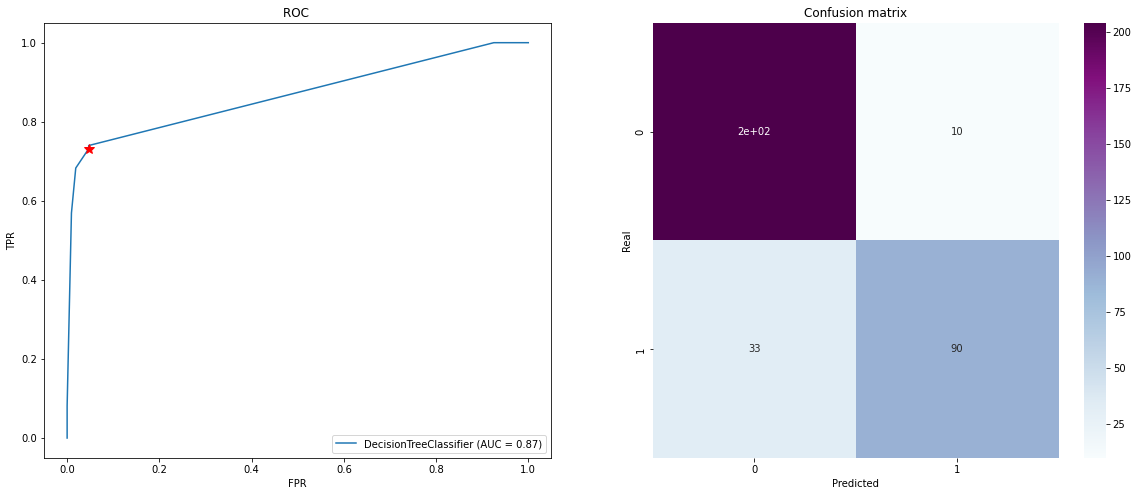

In [99]:
metrics(Dtree_best, y_test, X_test, 'Decision tree')

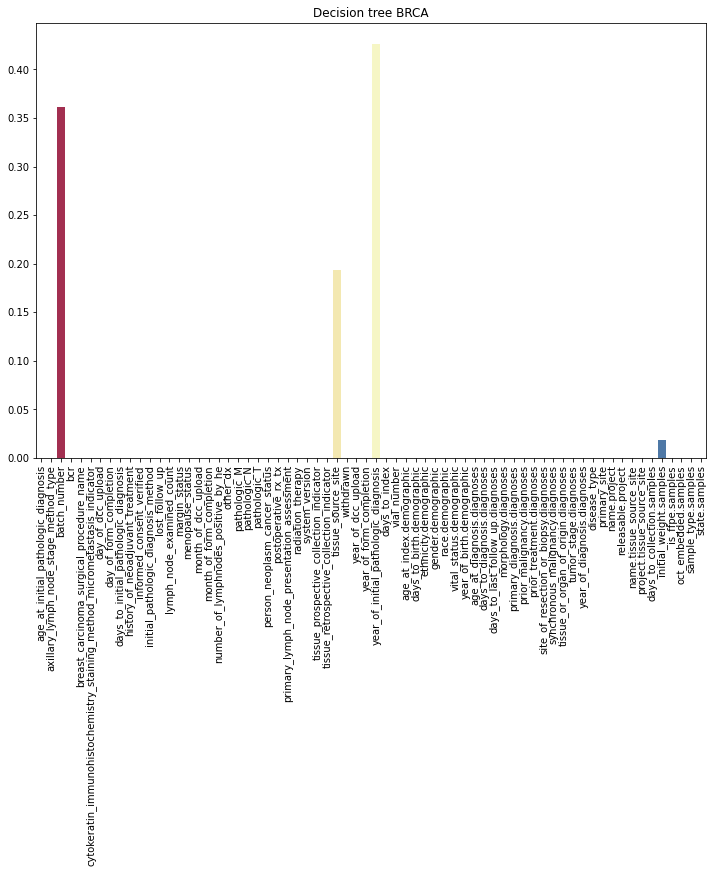

In [100]:
plt.figure(figsize = (12, 8))
sns.barplot(x = data.columns, y = Dtree_best.feature_importances_, palette = 'Spectral')
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Decision tree BRCA');

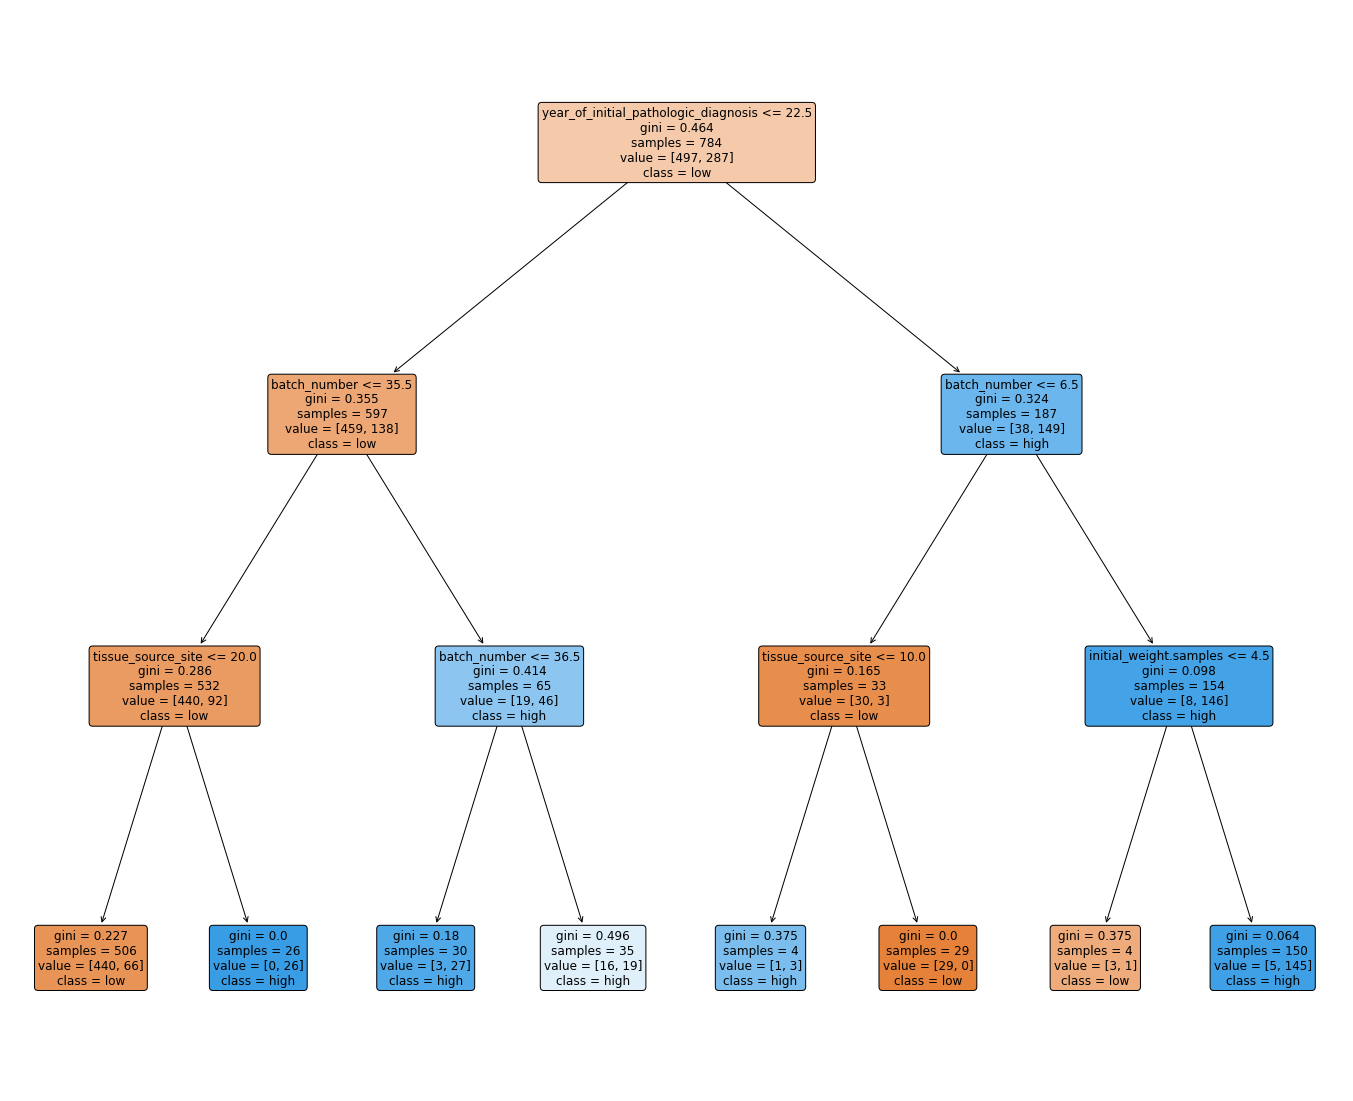

In [101]:
plt.figure(figsize = (24, 20))
plot_tree(Dtree_best,fontsize = 12, feature_names = data.columns, 
          class_names = ['low', 'high'], filled=True, rounded=True)
plt.show()

In [102]:
mirna22 = df_cancer.loc["hsa-miR-22-3p|+1|0"] 

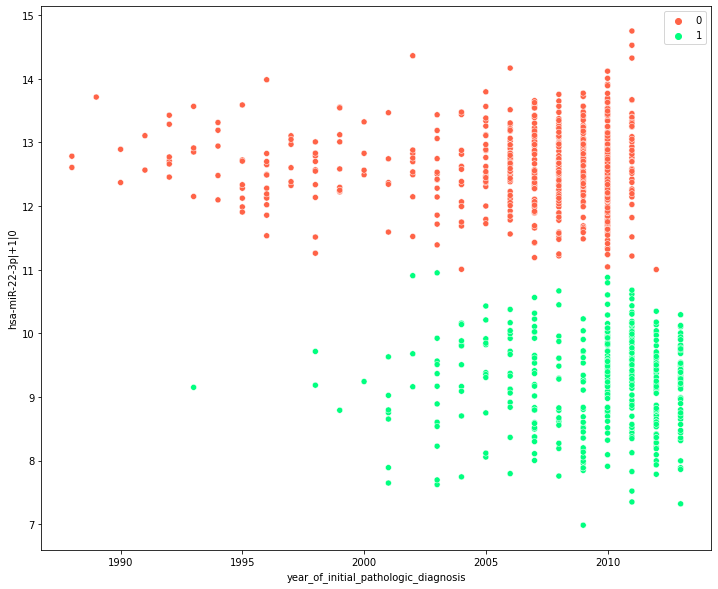

In [103]:
year = pd.concat([data, mirna22], axis=1)[["hsa-miR-22-3p|+1|0", "year_of_initial_pathologic_diagnosis"]]
y = np.array([1 if i in left else 0 for i in year.index])

plt.figure(figsize=(12, 10))
sns.scatterplot(x = "year_of_initial_pathologic_diagnosis", y = "hsa-miR-22-3p|+1|0", data = year,
               hue = y, palette = ["tomato", "springgreen"]);

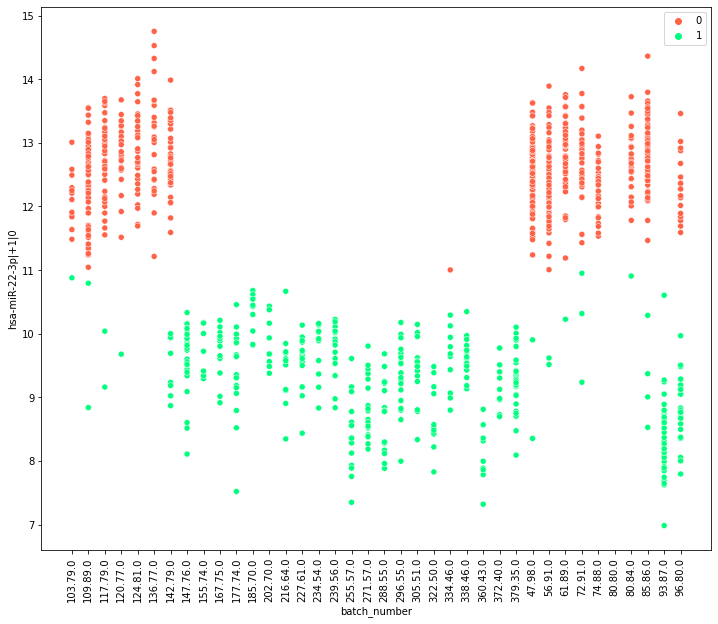

In [104]:
# new_b = list(map(lambda i: int(i.split('.')[0]) + int(i.split('.')[1])/100, data["batch_number"].values))
# data['batch_number'] = new_b
data = data.sort_values(by = 'batch_number')
data['batch_number'] = data['batch_number'].astype(str)

batch = pd.concat([data, mirna22], axis=1)[["hsa-miR-22-3p|+1|0", "batch_number"]]
y = np.array([1 if i in left else 0 for i in batch.index])

plt.figure(figsize=(12, 10))
sns.scatterplot(x = "batch_number", y = "hsa-miR-22-3p|+1|0", data = batch,
               hue = y, palette = ["tomato", "springgreen"])
plt.tick_params(axis='x', labelrotation = 90);

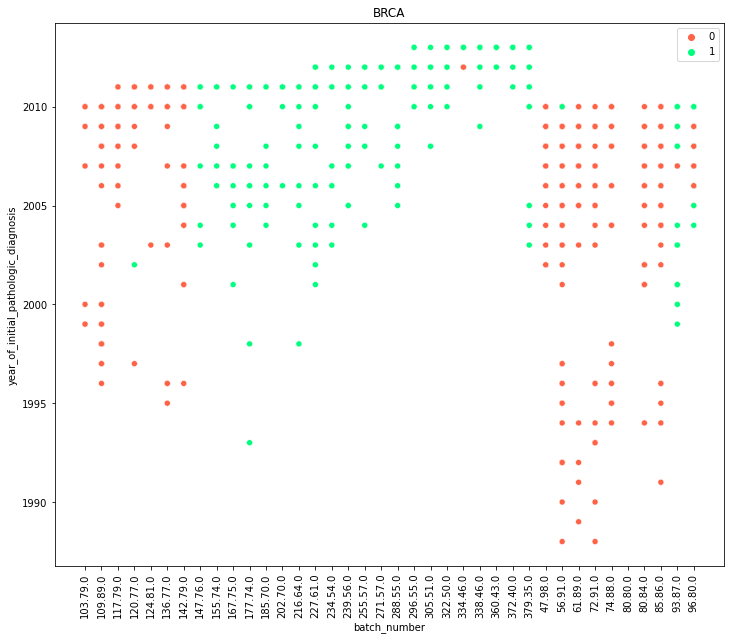

In [105]:
batch_year = pd.concat([data, mirna22], axis=1)[["year_of_initial_pathologic_diagnosis", 
                                                 "batch_number", "hsa-miR-22-3p|+1|0"]]
y = np.array([1 if i in left else 0 for i in batch_year.index])

plt.figure(figsize=(12, 10))
sns.scatterplot(x = "batch_number", y = "year_of_initial_pathologic_diagnosis", data = batch_year,
               hue = y, palette = ["tomato", "springgreen"])
plt.title('BRCA')
plt.tick_params(axis='x', labelrotation = 90);

## Random forest

,Accuracy,ROC-AUC,Precision,Recall
Random forest,0.581602,0.485601,0.32,0.130081


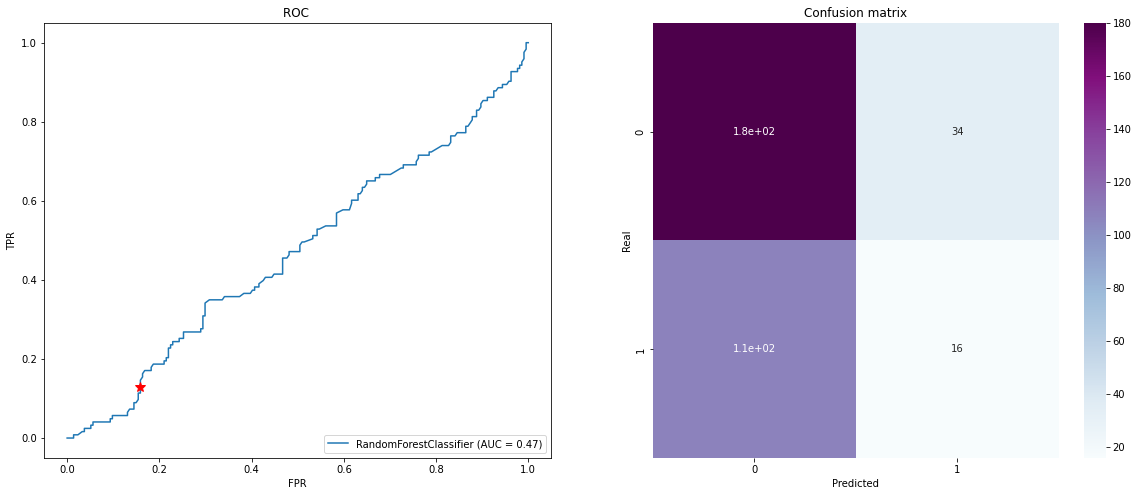

In [77]:
metrics(Random_forest_best, y_test, X_test, 'Random forest')

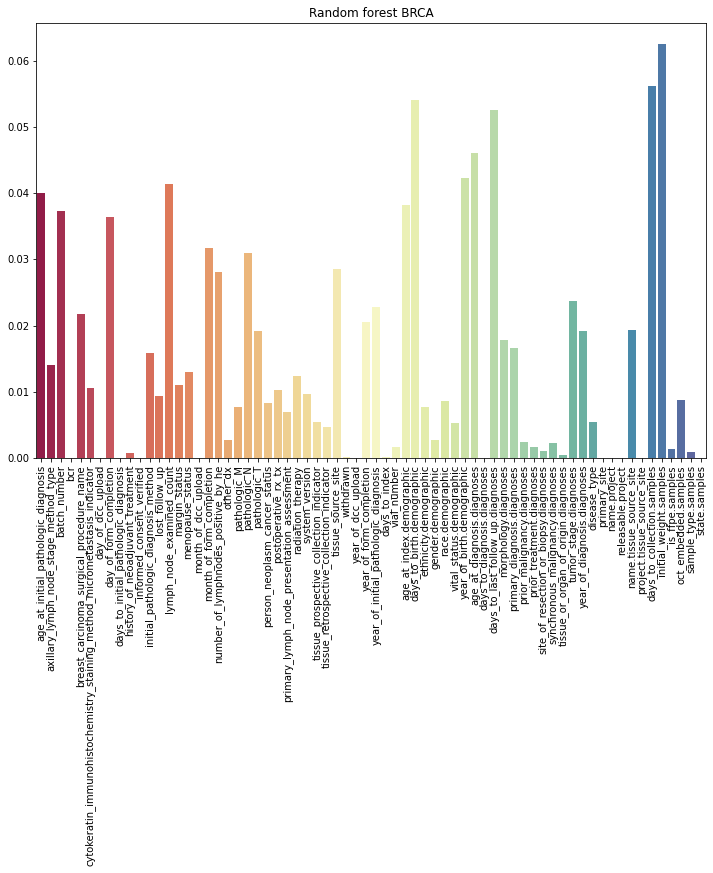

In [78]:
plt.figure(figsize = (12, 8))
sns.barplot(x = data.columns, y = Random_forest_best.feature_importances_, palette = 'Spectral')
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Random forest BRCA');

## Bagging

,Accuracy,ROC-AUC,Precision,Recall
Bagging,0.635015,0.5,0.0,0.0


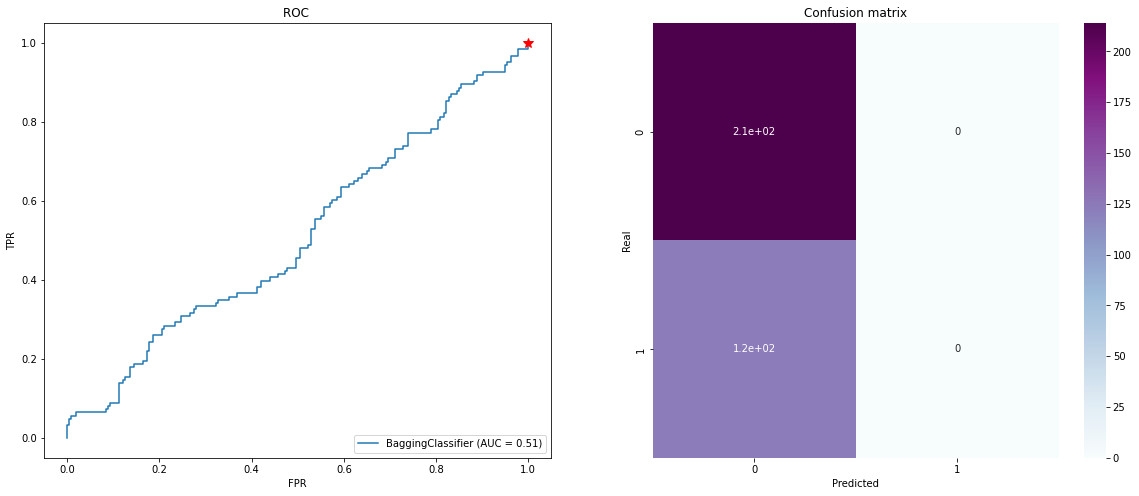

In [79]:
metrics(Bagging, y_test, X_test, 'Bagging')

In [80]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in Bagging.estimators_
], axis=0)

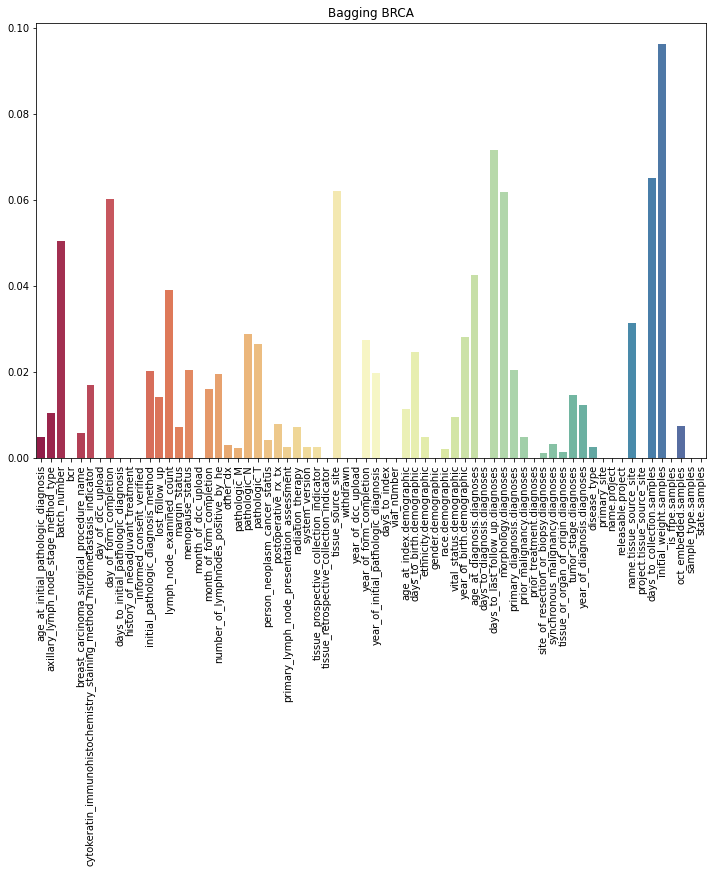

In [81]:
plt.figure(figsize = (12, 8))
sns.barplot(x = data.columns, y = feature_importances, palette = 'Spectral')
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Bagging BRCA');